### Melanoma and tumor-infiltrating lymphocyte examples

This notebook prepares Perturb-seq datasets from [Frangieh et al.](https://www.nature.com/articles/s41588-021-00779-1), a project on melanoma immune checkpoint inhibitor resistance. CRISPR knockouts of ~250 genes were applied to melanoma cells, and then the melanoma cells were treated in a variety of ways, including control, interferon gamma, and co-culture with tumor infiltrating lymphocytes. The idea is to see what mutations in melanoma might protect the melanoma from the lymphocytes. The paper included low-dimensional readouts based on melanoma survival and also perturb-seq readouts, which included mostly melanoma with minimal T cell contamination. 

Here we tidy the dataset and carry out a simple exploration in scanpy.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
import scipy
from IPython.display import display, HTML
import functools
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbations/")

### Load expression data & set up cell metadata

In [3]:
dataset_name = "frangieh"
expression_quantified = sc.read_csv(f"not_ready/{dataset_name}/RNA_expression.csv.gz")
expression_quantified.X = scipy.sparse.csr_matrix(expression_quantified.X)
expression_quantified = expression_quantified.T

In [4]:
cell_meta = pd.read_csv(f"not_ready/{dataset_name}/all_sgRNA_assignments.txt")
cell_meta.index = cell_meta["Cell"]
expression_quantified.obs = cell_meta
expression_quantified.obs
expression_quantified.raw = expression_quantified.copy()


In [5]:
sc.pp.calculate_qc_metrics(expression_quantified, inplace = True)

In [34]:
guides = functools.reduce(lambda a,b: a.union(b), [set(str(s).split(",")) for s in expression_quantified.obs["sgRNAs"]])
def get_target(guide):
    return re.sub("_[0-9]*$", "", guide) 
def is_control(target):
    return "SITE" in target
human_tfs = pd.read_csv("../accessory_data/humanTFs.csv")
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
set([get_target(g) for g in guides ]).intersection(human_tfs["HGNC symbol"])

{'AEBP1',
 'DNMT1',
 'E2F1',
 'EEA1',
 'FOS',
 'FOXM1',
 'IRF3',
 'IRF4',
 'KLF4',
 'MYC',
 'SMAD3',
 'SMAD4',
 'SOX4',
 'SP100',
 'STAT1',
 'STAT3',
 'TFAP2A',
 'TP53'}

### Fill `perturbation` & `Is_control`

In [47]:
expression_quantified.obs["targets"] = [
    ",".join(
                [
                    get_target(g) for g in str(s).split(",") if not is_control(get_target(g))
                ]
        ) 
    for s in expression_quantified.obs["sgRNAs"]
]
expression_quantified.obs["targets"].value_counts(dropna = False)

nan                     22253
                        16262
IFNGR2                    917
JAK2                      830
MFGE8                     808
                        ...  
CKS1B,GRN,LINC00518         1
B2M,CCND1                   1
AGA,CTPS1                   1
SLC19A1,TIMM50,TIMP1        1
IRF3,JAK1                   1
Name: targets, Length: 35335, dtype: int64

In [48]:

expression_quantified.obs["perturbation"] = expression_quantified.obs['targets']
expression_quantified.obs["is_control"]   = [t in {"nan", ""} for t in expression_quantified.obs['targets']]
expression_quantified.obs["is_control_int"]   = expression_quantified.obs["is_control"].astype(int)
expression_quantified.obs["is_control"].value_counts(dropna = False)

False    178496
True      38515
Name: is_control, dtype: int64

### QC filters

In [8]:
expression_quantified = expression_quantified[expression_quantified.obs["total_counts"]>= 6000, :]
expression_quantified = expression_quantified[expression_quantified.obs["pct_counts_in_top_50_genes"]<= 10, :]
expression_quantified

View of AnnData object with n_obs × n_vars = 217011 × 23712
    obs: 'Cell', 'sgRNAs', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'targets', 'perturbation', 'is_control', 'is_control_int'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Basic EDA

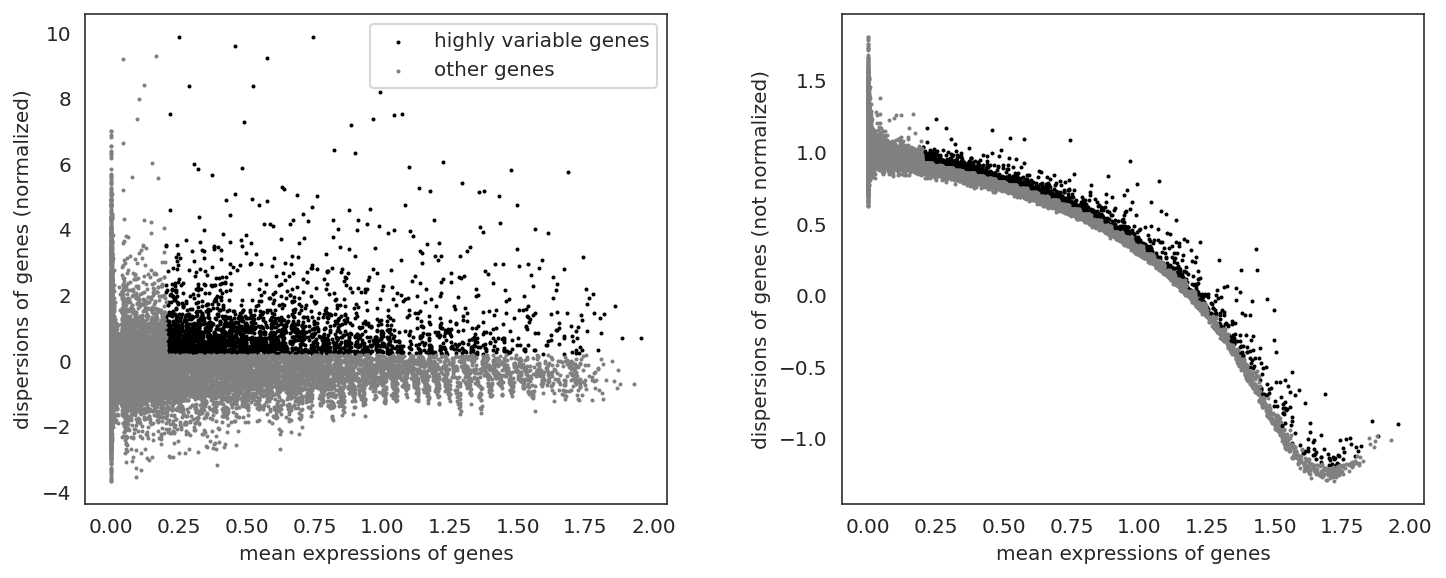

In [9]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)

sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
cc_genes = pd.read_csv("../accessory_data/regev_lab_cell_cycle_genes.txt", header = None)[0]
sc.tl.score_genes_cell_cycle(expression_quantified, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])

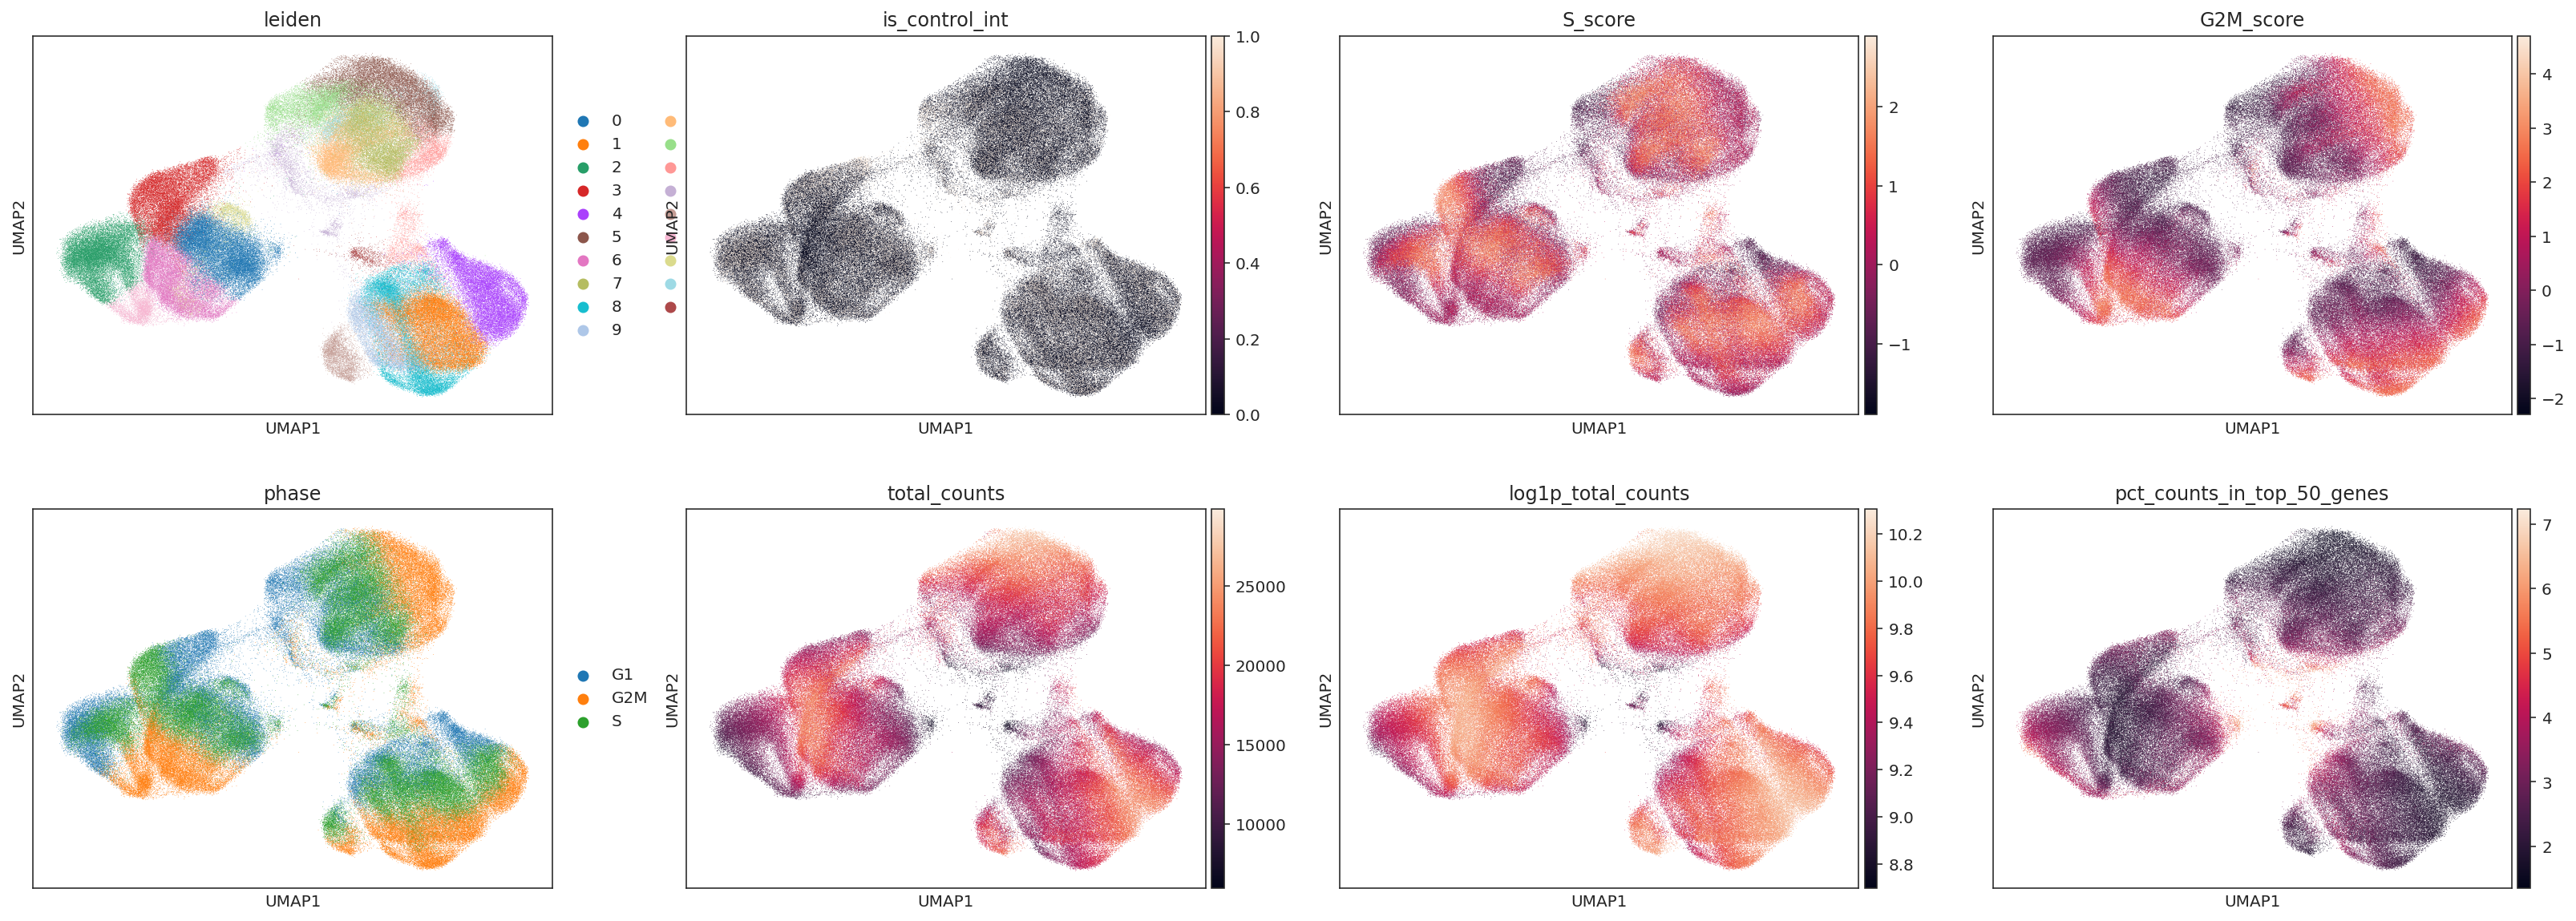

In [49]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(expression_quantified, color = [
    "leiden", 
    "is_control_int",
    'S_score',
    'G2M_score', 
    'phase', 
    'total_counts', 
    'log1p_total_counts',
    'pct_counts_in_top_50_genes', 
])
# Will ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [50]:
perturbed_genes = targets
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
print("These genes were perturbed:")
print(perturbed_genes)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

These genes were perturbed:
{'MFGE8', 'CST3', 'TIMP1', 'GPATCH4', 'IDH2', 'RNASEH2A', 'ROMO1', 'FOXM1', 'HNRNPA1', 'RPSA', 'WBP2', 'JAK1', 'TMEM173', 'IFNGR2', 'DAG1', 'EIF4A1', 'C19orf48', 'CDK6', 'SLC19A1', 'FMN1', 'ENPP1', 'SLC22A18', 'TPRKB', 'CD47', 'APOD', 'FTH1', 'LGALS3', 'PSMA7', 'HLA-H', 'CDKN2B', 'CCT3', 'ITGA3', 'RRS1', 'UQCRH', 'JMJD7', 'SLC26A2', 'VAT1', 'CXCR4', 'NCL', 'TP53', 'ST3GAL6-AS1', 'CTSA', 'FBL', 'RB1', 'CSPG4', 'NSG1', 'TM4SF1', 'DLL3', 'CD63', 'CD44', 'CHCHD2', 'AHNAK', 'CTSD', 'TAPBP', 'S100A6', 'HLA-A', 'CKS1B', 'APOC2', 'DDX17', 'HNRNPC', 'CCT6A', 'PTMA', 'CCR10', 'SDC3', 'STAT3', 'FRZB', 'EVA1A', 'APOE', 'SEC11C', 'FOS', 'LAMP2', 'SINHCAF', 'CORO1A', 'C6orf226', 'TRIM22', 'SAE1', 'CITED1', 'RNF213', 'CD151', 'ILF2', 'AHCY', 'PET100', 'TPP1', 'LRPAP1', 'SDCBP', 'CTSB', 'P2RX4', 'CDH19', 'CCND2', 'RAB27A', 'ACSL3', 'CDKN1A', 'CCND1', 'STX7', 'SOX4', 'CTSL', 'BOLA2', 'TAPBPL', 'RACK1', 'IRF4', 'DNAJC9', 'SPINT1', 'PYGB', 'LCP1', 'WNT7A', 'TFAP2A', 'SNRPG', '

In [51]:
# final form, ready to save
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
expression_quantified.uns["perturbations_overlap"] = True
expression_quantified.obs["perturbation_type"] = "knockout" 
expression_quantified.obs["expression_level_after_perturbation"] = 0 

In [52]:
perturbed_but_not_measured_genes
all_genes_hit = set.union(*[set(p.split(",")) for p in expression_quantified.obs["perturbation"]])     

In [53]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
expression_quantified.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")